# Anotações para próximo projeto:
- Testar diversos parâmetros para o modelo;
- Excluir colunas e avaliar resultados;
- Tratar colunas com diversos valores para intervalos de valores;
- Verificar principais variáveis que o modelo utiliza (e seus pesos) na hora da predição;

# Análise

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
dataset = pd.read_csv("../data/train/telecom_churn_train.csv")
dataset

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


- Churn:
1 if customer cancelled service, 0 if not

- AccountWeeks:
number of weeks customer has had active account

- ContractRenewal:
1 if customer recently renewed contract, 0 if not

- DataPlan:
1 if customer has data plan, 0 if not

- DataUsage:
gigabytes of monthly data usage

- CustServCalls:
number of calls into customer service

- DayMins:
average daytime minutes per month

- DayCalls:
average number of daytime calls

- MonthlyCharge:
average monthly bill

- OverageFee:
largest overage fee in last 12 months

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [0]:
dataset.duplicated().sum()

np.int64(0)

<Axes: xlabel='count', ylabel='Churn'>

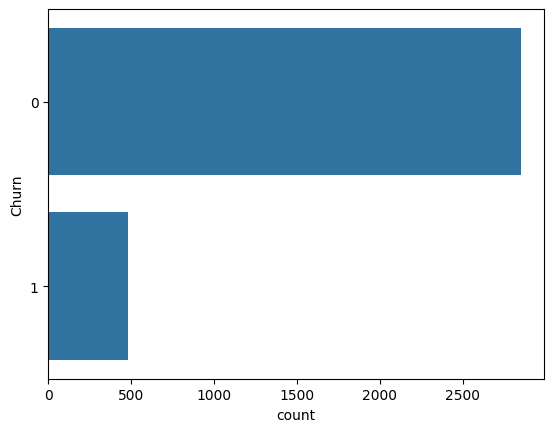

In [0]:
sns.countplot(dataset['Churn'].astype('category'))

- Base de dados desproporcional, Churn = 0 é muito maior que Churn = 1;
- Na hora de treinar, testar undersampling e oversampling;
- Na hora de dividir a base de treinar e teste, usar stratify;

<Axes: >

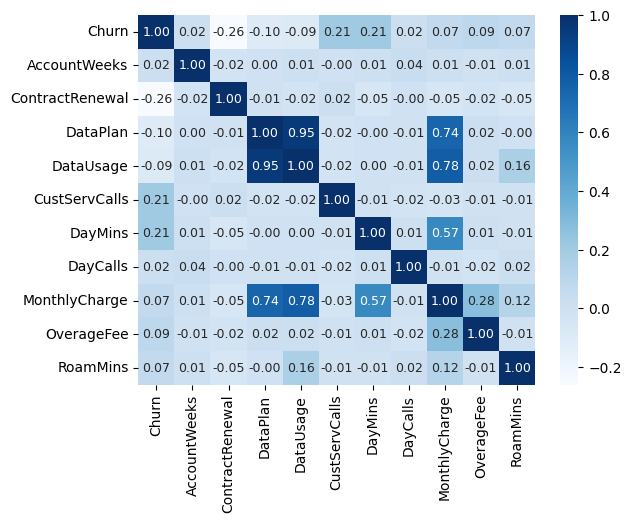

In [0]:
sns.heatmap(dataset.corr().round(2), annot=True, cmap='Blues', annot_kws={"size": 9}, fmt=".2f")

In [0]:
dataset.groupby('ContractRenewal')['Churn'].mean()

ContractRenewal
0    0.424149
1    0.114950
Name: Churn, dtype: float64

- Cerca de 42,4% dos clientes que NÃO renovaram o contrato churnaram (cancelaram o plano)
- Cerca de 11,5% dos clientes que renovaram o contrato churnaram
- Clientes que não renovam contrato têm quase 4 vezes mais chance de churn do que os que renovam.

In [0]:
dataset.groupby('CustServCalls')['Churn'].mean()

CustServCalls
0    0.131994
1    0.103302
2    0.114625
3    0.102564
4    0.457831
5    0.606061
6    0.636364
7    0.555556
8    0.500000
9    1.000000
Name: Churn, dtype: float64

- A partir de 4 chamadas, a taxa de cancelamento aumenta significamente;
- Após 9 chamadas, 100% dos clientes cancelaram;

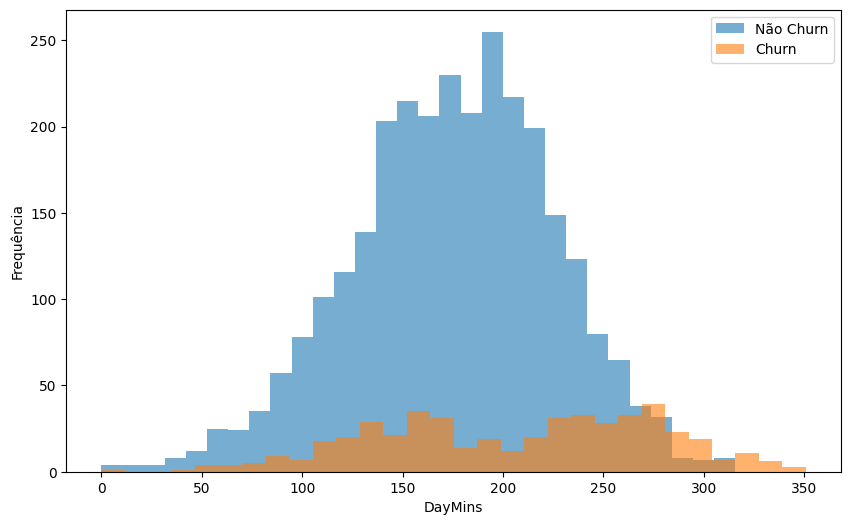

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.hist(
    dataset[dataset['Churn'] == 0]['DayMins'],
    bins=30,
    alpha=0.6,
    label='Não Churn'
)

plt.hist(
    dataset[dataset['Churn'] == 1]['DayMins'],
    bins=30,
    alpha=0.6,
    label='Churn'
)

plt.xlabel('DayMins')
plt.ylabel('Frequência')
plt.legend()
plt.show()


In [0]:
dataset.groupby('DataPlan')['Churn'].mean()

DataPlan
0    0.167151
1    0.086768
Name: Churn, dtype: float64

# Modelagem

In [0]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [0]:
X = dataset.drop(['Churn'], axis=1)
y = dataset['Churn']
# Focar na avaliação de recall, pois queremos que o modelo identifique corretamente os clientes que vão cancelar o plano.

In [0]:
naive_bayes_results = {}
logistic_regression_results = {}
random_forest_results = {}
naive_acuracy, naive_recall = [], []
logistic_acuracy, logistic_recall = [], []
forest_acuracy, forest_recall = [], []

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000))
])

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    naive_bayes = GaussianNB()
    naive_bayes_scores = cross_val_score(naive_bayes, X, y, cv=kfold)
    naive_bayes_recalls = cross_val_score(naive_bayes, X, y, cv=kfold, scoring='recall')
    naive_acuracy.append(naive_bayes_scores.mean())
    naive_recall.append(naive_bayes_recalls.mean())

    logistic_regression = LogisticRegression()
    logistic_regression_scores = cross_val_score(pipeline, X, y, cv=kfold)
    logistic_regression_recalls = cross_val_score(pipeline, X, y, cv=kfold, scoring='recall')
    logistic_acuracy.append(logistic_regression_scores.mean())
    logistic_recall.append(logistic_regression_recalls.mean())

    random_forest = RandomForestClassifier()
    random_forest_scores = cross_val_score(random_forest, X, y, cv=kfold)
    random_forest_recalls = cross_val_score(random_forest, X, y, cv=kfold, scoring='recall')
    forest_acuracy.append(random_forest_scores.mean())
    forest_recall.append(random_forest_recalls.mean())
    
naive_bayes_results['accuracy'] = naive_acuracy
naive_bayes_results['recall'] = naive_recall
logistic_regression_results['accuracy'] = logistic_acuracy
logistic_regression_results['recall'] = logistic_recall
random_forest_results['accuracy'] = forest_acuracy
random_forest_results['recall'] = forest_recall

## Analisar:
- Média/Mediana/Moda dos resultados;
- Desvio padrão dos resultados;
- Coeficiente de variação dos resultados;

In [0]:
import numpy as np
from scipy import stats

In [0]:
# Médias
acuracia_media_naive = np.mean(naive_bayes_results['accuracy'])
acuracia_media_logistic = np.mean(logistic_regression_results['accuracy'])
acuracia_media_forest = np.mean(random_forest_results['accuracy'])
recall_media_naive = np.mean(naive_bayes_results['recall'])
recall_media_logistic = np.mean(logistic_regression_results['recall'])
recall_media_forest = np.mean(random_forest_results['recall'])

# Mediana
acuracia_mediana_naive = np.median(naive_bayes_results['accuracy'])
acuracia_mediana_logistic = np.median(logistic_regression_results['accuracy'])
acuracia_mediana_forest = np.median(random_forest_results['accuracy'])
recall_mediana_naive = np.median(naive_bayes_results['recall'])
recall_mediana_logistic = np.median(logistic_regression_results['recall'])
recall_mediana_forest = np.median(random_forest_results['recall'])

# Moda
acuracia_moda_naive = stats.mode(naive_bayes_results['accuracy'])
acuracia_moda_logistic = stats.mode(logistic_regression_results['accuracy'])
acuracia_moda_forest = stats.mode(random_forest_results['accuracy'])
recall_moda_naive = stats.mode(naive_bayes_results['recall'])
recall_moda_logistic = stats.mode(logistic_regression_results['recall'])
recall_moda_forest = stats.mode(random_forest_results['recall'])

# Desvio Padrão
acuracia_desvio_naive = np.std(naive_bayes_results['accuracy'])
acuracia_desvio_logistic = np.std(logistic_regression_results['accuracy'])
acuracia_desvio_forest = np.std(random_forest_results['accuracy'])
recall_desvio_naive = np.std(naive_bayes_results['recall'])
recall_desvio_logistic = np.std(logistic_regression_results['recall'])
recall_desvio_forest = np.std(random_forest_results['recall'])

# Coeficiente de Variação
acuracia_cv_naive = acuracia_desvio_naive/acuracia_media_naive
acuracia_cv_logistic = acuracia_desvio_logistic/acuracia_media_logistic
acuracia_cv_forest = acuracia_desvio_forest/acuracia_media_forest
recall_cv_naive = recall_desvio_naive/recall_media_naive
recall_cv_logistic = recall_desvio_logistic/recall_media_logistic
recall_cv_forest = recall_desvio_forest/recall_media_forest

In [0]:
print(
    f"""
Média dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_media_naive:.4f}{"":<33}Naive Bayes: {recall_media_naive:.4f}
Logistic Regression: {acuracia_media_logistic:.4f}{"":<25}Logistic Regression: {recall_media_logistic:.4f}
Random Forest: {acuracia_media_forest:.4f}{"":<31}Random Forest: {recall_media_forest:.4f}

Mediana dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_mediana_naive:.4f}{"":<33}Naive Bayes: {recall_mediana_naive:.4f}
Logistic Regression: {acuracia_mediana_logistic:.4f}{"":<25}Logistic Regression: {recall_mediana_logistic:.4f}
Random Forest: {acuracia_mediana_forest:.4f}{"":<31}Random Forest: {recall_mediana_forest:.4f}

Moda dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_moda_naive.mode:.4f}{"":<33}Naive Bayes: {recall_moda_naive.mode:.4f}
Logistic Regression: {acuracia_moda_logistic.mode:.4f}{"":<25}Logistic Regression: {recall_moda_logistic.mode:.4f}
Random Forest: {acuracia_moda_forest.mode:.4f}{"":<31}Random Forest: {recall_moda_forest.mode:.4f}

Desvio Padrão dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_desvio_naive:.4f}{"":<33}Naive Bayes: {recall_desvio_naive:.4f}
Logistic Regression: {acuracia_desvio_logistic:.4f}{"":<25}Logistic Regression: {recall_desvio_logistic:.4f}
Random Forest: {acuracia_desvio_forest:.4f}{"":<31}Random Forest: {recall_desvio_forest:.4f}

Coeficiente de Variação dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_cv_naive:.4f}{"":<33}Naive Bayes: {recall_cv_naive:.4f}
Logistic Regression: {acuracia_cv_logistic:.4f}{"":<25}Logistic Regression: {recall_cv_logistic:.4f}
Random Forest: {acuracia_cv_forest:.4f}{"":<31}Random Forest: {recall_cv_forest:.4f}
"""
)



Média dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8495                                 Naive Bayes: 0.4255
Logistic Regression: 0.8598                         Logistic Regression: 0.1809
Random Forest: 0.9366                               Random Forest: 0.6634

Mediana dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8494                                 Naive Bayes: 0.4255
Logistic Regression: 0.8600                         Logistic Regression: 0.1813
Random Forest: 0.9364                               Random Forest: 0.6623

Moda dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8497                                 Naive Bayes: 0.4175
Logistic Regression: 0.8605                         Logistic Regression: 0.1724
Random Forest: 0.9367                               Random Forest: 0.6499

Desvio Padrão dos modelos:
----- Acurácia -----

- Recall muito baixo para os modelos;

## Undersampling

In [0]:
from imblearn.under_sampling import TomekLinks

In [0]:
tl = TomekLinks(sampling_strategy = 'majority')
X_tl, y_tl= tl.fit_resample(X, y)
X_tl.shape, y_tl.shape

((3181, 10), (3181,))

In [0]:
naive_bayes_results = {}
logistic_regression_results = {}
random_forest_results = {}
naive_acuracy, naive_recall = [], []
logistic_acuracy, logistic_recall = [], []
forest_acuracy, forest_recall = [], []

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000))
])

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    naive_bayes = GaussianNB()
    naive_bayes_scores = cross_val_score(naive_bayes, X_tl, y_tl, cv=kfold)
    naive_bayes_recalls = cross_val_score(naive_bayes, X_tl, y_tl, cv=kfold, scoring='recall')
    naive_acuracy.append(naive_bayes_scores.mean())
    naive_recall.append(naive_bayes_recalls.mean())

    logistic_regression = LogisticRegression()
    logistic_regression_scores = cross_val_score(pipeline, X_tl, y_tl, cv=kfold)
    logistic_regression_recalls = cross_val_score(pipeline, X_tl, y_tl, cv=kfold, scoring='recall')
    logistic_acuracy.append(logistic_regression_scores.mean())
    logistic_recall.append(logistic_regression_recalls.mean())

    random_forest = RandomForestClassifier()
    random_forest_scores = cross_val_score(random_forest, X_tl, y_tl, cv=kfold)
    random_forest_recalls = cross_val_score(random_forest, X_tl, y_tl, cv=kfold, scoring='recall')
    forest_acuracy.append(random_forest_scores.mean())
    forest_recall.append(random_forest_recalls.mean())
    
naive_bayes_results['accuracy'] = naive_acuracy
naive_bayes_results['recall'] = naive_recall
logistic_regression_results['accuracy'] = logistic_acuracy
logistic_regression_results['recall'] = logistic_recall
random_forest_results['accuracy'] = forest_acuracy
random_forest_results['recall'] = forest_recall

In [0]:
# Médias
acuracia_media_naive_tl = np.mean(naive_bayes_results['accuracy'])
acuracia_media_logistic_tl = np.mean(logistic_regression_results['accuracy'])
acuracia_media_forest_tl = np.mean(random_forest_results['accuracy'])
recall_media_naive_tl = np.mean(naive_bayes_results['recall'])
recall_media_logistic_tl = np.mean(logistic_regression_results['recall'])
recall_media_forest_tl = np.mean(random_forest_results['recall'])

# Mediana
acuracia_mediana_naive_tl = np.median(naive_bayes_results['accuracy'])
acuracia_mediana_logistic_tl = np.median(logistic_regression_results['accuracy'])
acuracia_mediana_forest_tl = np.median(random_forest_results['accuracy'])
recall_mediana_naive_tl = np.median(naive_bayes_results['recall'])
recall_mediana_logistic_tl = np.median(logistic_regression_results['recall'])
recall_mediana_forest_tl = np.median(random_forest_results['recall'])

# Moda
acuracia_moda_naive_tl = stats.mode(naive_bayes_results['accuracy'])
acuracia_moda_logistic_tl = stats.mode(logistic_regression_results['accuracy'])
acuracia_moda_forest_tl = stats.mode(random_forest_results['accuracy'])
recall_moda_naive_tl = stats.mode(naive_bayes_results['recall'])
recall_moda_logistic_tl = stats.mode(logistic_regression_results['recall'])
recall_moda_forest_tl = stats.mode(random_forest_results['recall'])

# Desvio Padrão
acuracia_desvio_naive_tl = np.std(naive_bayes_results['accuracy'])
acuracia_desvio_logistic_tl = np.std(logistic_regression_results['accuracy'])
acuracia_desvio_forest_tl = np.std(random_forest_results['accuracy'])
recall_desvio_naive_tl = np.std(naive_bayes_results['recall'])
recall_desvio_logistic_tl = np.std(logistic_regression_results['recall'])
recall_desvio_forest_tl = np.std(random_forest_results['recall'])

# Coeficiente de Variação
acuracia_cv_naive_tl = acuracia_desvio_naive/acuracia_media_naive
acuracia_cv_logistic_tl = acuracia_desvio_logistic/acuracia_media_logistic
acuracia_cv_forest_tl = acuracia_desvio_forest/acuracia_media_forest
recall_cv_naive_tl = recall_desvio_naive/recall_media_naive
recall_cv_logistic_tl = recall_desvio_logistic/recall_media_logistic
recall_cv_forest_tl = recall_desvio_forest/recall_media_forest

In [0]:
print(
    f"""
Média dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_media_naive_tl:.4f}{"":<33}Naive Bayes: {recall_media_naive_tl:.4f}
Logistic Regression: {acuracia_media_logistic_tl:.4f}{"":<25}Logistic Regression: {recall_media_logistic_tl:.4f}
Random Forest: {acuracia_media_forest_tl:.4f}{"":<31}Random Forest: {recall_media_forest_tl:.4f}

Mediana dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_mediana_naive_tl:.4f}{"":<33}Naive Bayes: {recall_mediana_naive_tl:.4f}
Logistic Regression: {acuracia_mediana_logistic_tl:.4f}{"":<25}Logistic Regression: {recall_mediana_logistic_tl:.4f}
Random Forest: {acuracia_mediana_forest_tl:.4f}{"":<31}Random Forest: {recall_mediana_forest_tl:.4f}

Moda dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_moda_naive_tl.mode:.4f}{"":<33}Naive Bayes: {recall_moda_naive_tl.mode:.4f}
Logistic Regression: {acuracia_moda_logistic_tl.mode:.4f}{"":<25}Logistic Regression: {recall_moda_logistic_tl.mode:.4f}
Random Forest: {acuracia_moda_forest_tl.mode:.4f}{"":<31}Random Forest: {recall_moda_forest_tl.mode:.4f}

Desvio Padrão dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_desvio_naive_tl:.4f}{"":<33}Naive Bayes: {recall_desvio_naive_tl:.4f}
Logistic Regression: {acuracia_desvio_logistic_tl:.4f}{"":<25}Logistic Regression: {recall_desvio_logistic_tl:.4f}
Random Forest: {acuracia_desvio_forest_tl:.4f}{"":<31}Random Forest: {recall_desvio_forest_tl:.4f}

Coeficiente de Variação dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_cv_naive_tl:.4f}{"":<33}Naive Bayes: {recall_cv_naive_tl:.4f}
Logistic Regression: {acuracia_cv_logistic_tl:.4f}{"":<25}Logistic Regression: {recall_cv_logistic_tl:.4f}
Random Forest: {acuracia_cv_forest_tl:.4f}{"":<31}Random Forest: {recall_cv_forest_tl:.4f}
"""
)



Média dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8479                                 Naive Bayes: 0.4381
Logistic Regression: 0.8541                         Logistic Regression: 0.2042
Random Forest: 0.9373                               Random Forest: 0.6769

Mediana dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8479                                 Naive Bayes: 0.4384
Logistic Regression: 0.8541                         Logistic Regression: 0.2039
Random Forest: 0.9374                               Random Forest: 0.6769

Moda dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8475                                 Naive Bayes: 0.4293
Logistic Regression: 0.8541                         Logistic Regression: 0.1949
Random Forest: 0.9378                               Random Forest: 0.6665

Desvio Padrão dos modelos:
----- Acurácia -----

## Oversampling

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
X = X.astype(float)
smote = SMOTE(sampling_strategy = 'minority')
X_smote, y_smote = smote.fit_resample(X, y)
X_smote.shape, y_smote.shape

((5700, 10), (5700,))

In [0]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000))
])


In [0]:
naive_bayes_results = {}
logistic_regression_results = {}
random_forest_results = {}
naive_acuracy, naive_recall = [], []
logistic_acuracy, logistic_recall = [], []
forest_acuracy, forest_recall = [], []

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    naive_bayes = GaussianNB()
    naive_bayes_scores = cross_val_score(naive_bayes, X_smote, y_smote, cv=kfold)
    naive_bayes_recalls = cross_val_score(naive_bayes, X_smote, y_smote, cv=kfold, scoring='recall')
    naive_acuracy.append(naive_bayes_scores.mean())
    naive_recall.append(naive_bayes_recalls.mean())

    logistic_regression = LogisticRegression()
    logistic_regression_scores = cross_val_score(pipeline, X_smote, y_smote, cv=kfold)
    logistic_regression_recalls = cross_val_score(pipeline, X_smote, y_smote, cv=kfold, scoring='recall')
    logistic_acuracy.append(logistic_regression_scores.mean())
    logistic_recall.append(logistic_regression_recalls.mean())

    random_forest = RandomForestClassifier()
    random_forest_scores = cross_val_score(random_forest, X_smote, y_smote, cv=kfold)
    random_forest_recalls = cross_val_score(random_forest, X_smote, y_smote, cv=kfold, scoring='recall')
    forest_acuracy.append(random_forest_scores.mean())
    forest_recall.append(random_forest_recalls.mean())
    
naive_bayes_results['accuracy'] = naive_acuracy
naive_bayes_results['recall'] = naive_recall
logistic_regression_results['accuracy'] = logistic_acuracy
logistic_regression_results['recall'] = logistic_recall
random_forest_results['accuracy'] = forest_acuracy
random_forest_results['recall'] = forest_recall

In [0]:
# Médias
acuracia_media_naive_smote = np.mean(naive_bayes_results['accuracy'])
acuracia_media_logistic_smote = np.mean(logistic_regression_results['accuracy'])
acuracia_media_forest_smote = np.mean(random_forest_results['accuracy'])
recall_media_naive_smote = np.mean(naive_bayes_results['recall'])
recall_media_logistic_smote = np.mean(logistic_regression_results['recall'])
recall_media_forest_smote = np.mean(random_forest_results['recall'])

# Mediana
acuracia_mediana_naive_smote = np.median(naive_bayes_results['accuracy'])
acuracia_mediana_logistic_smote = np.median(logistic_regression_results['accuracy'])
acuracia_mediana_forest_smote = np.median(random_forest_results['accuracy'])
recall_mediana_naive_smote = np.median(naive_bayes_results['recall'])
recall_mediana_logistic_smote = np.median(logistic_regression_results['recall'])
recall_mediana_forest_smote = np.median(random_forest_results['recall'])

# Moda
acuracia_moda_naive_smote = stats.mode(naive_bayes_results['accuracy'])
acuracia_moda_logistic_smote = stats.mode(logistic_regression_results['accuracy'])
acuracia_moda_forest_smote = stats.mode(random_forest_results['accuracy'])
recall_moda_naive_smote = stats.mode(naive_bayes_results['recall'])
recall_moda_logistic_smote = stats.mode(logistic_regression_results['recall'])
recall_moda_forest_smote = stats.mode(random_forest_results['recall'])

# Desvio Padrão
acuracia_desvio_naive_smote = np.std(naive_bayes_results['accuracy'])
acuracia_desvio_logistic_smote = np.std(logistic_regression_results['accuracy'])
acuracia_desvio_forest_smote = np.std(random_forest_results['accuracy'])
recall_desvio_naive_smote = np.std(naive_bayes_results['recall'])
recall_desvio_logistic_smote = np.std(logistic_regression_results['recall'])
recall_desvio_forest_smote = np.std(random_forest_results['recall'])

# Coeficiente de Variação
acuracia_cv_naive_smote = acuracia_desvio_naive/acuracia_media_naive
acuracia_cv_logistic_smote = acuracia_desvio_logistic/acuracia_media_logistic
acuracia_cv_forest_smote = acuracia_desvio_forest/acuracia_media_forest
recall_cv_naive_smote = recall_desvio_naive/recall_media_naive
recall_cv_logistic_smote = recall_desvio_logistic/recall_media_logistic
recall_cv_forest_smote = recall_desvio_forest/recall_media_forest

In [0]:
print(
    f"""
Média dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_media_naive_smote:.4f}{"":<33}Naive Bayes: {recall_media_naive_smote:.4f}
Logistic Regression: {acuracia_media_logistic_smote:.4f}{"":<25}Logistic Regression: {recall_media_logistic_smote:.4f}
Random Forest: {acuracia_media_forest_smote:.4f}{"":<31}Random Forest: {recall_media_forest_smote:.4f}

Mediana dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_mediana_naive_smote:.4f}{"":<33}Naive Bayes: {recall_mediana_naive_smote:.4f}
Logistic Regression: {acuracia_mediana_logistic_smote:.4f}{"":<25}Logistic Regression: {recall_mediana_logistic_smote:.4f}
Random Forest: {acuracia_mediana_forest_smote:.4f}{"":<31}Random Forest: {recall_mediana_forest_smote:.4f}

Moda dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_moda_naive_smote.mode:.4f}{"":<33}Naive Bayes: {recall_moda_naive_smote.mode:.4f}
Logistic Regression: {acuracia_moda_logistic_smote.mode:.4f}{"":<25}Logistic Regression: {recall_moda_logistic_smote.mode:.4f}
Random Forest: {acuracia_moda_forest_smote.mode:.4f}{"":<31}Random Forest: {recall_moda_forest_smote.mode:.4f}

Desvio Padrão dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_desvio_naive_smote:.4f}{"":<33}Naive Bayes: {recall_desvio_naive_smote:.4f}
Logistic Regression: {acuracia_desvio_logistic_smote:.4f}{"":<25}Logistic Regression: {recall_desvio_logistic_smote:.4f}
Random Forest: {acuracia_desvio_forest_smote:.4f}{"":<31}Random Forest: {recall_desvio_forest_smote:.4f}

Coeficiente de Variação dos modelos:
{'----- Acurácia -----':<52}{'----- Recall -----'}
Naive Bayes: {acuracia_cv_naive_smote:.4f}{"":<33}Naive Bayes: {recall_cv_naive_smote:.4f}
Logistic Regression: {acuracia_cv_logistic_smote:.4f}{"":<25}Logistic Regression: {recall_cv_logistic_smote:.4f}
Random Forest: {acuracia_cv_forest_smote:.4f}{"":<31}Random Forest: {recall_cv_forest_smote:.4f}
"""
)



Média dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8015                                 Naive Bayes: 0.8161
Logistic Regression: 0.7758                         Logistic Regression: 0.7765
Random Forest: 0.9504                               Random Forest: 0.9428

Mediana dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8017                                 Naive Bayes: 0.8161
Logistic Regression: 0.7760                         Logistic Regression: 0.7764
Random Forest: 0.9504                               Random Forest: 0.9431

Moda dos modelos:
----- Acurácia -----                                ----- Recall -----
Naive Bayes: 0.8028                                 Naive Bayes: 0.8129
Logistic Regression: 0.7747                         Logistic Regression: 0.7737
Random Forest: 0.9504                               Random Forest: 0.9386

Desvio Padrão dos modelos:
----- Acurácia -----

In [0]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

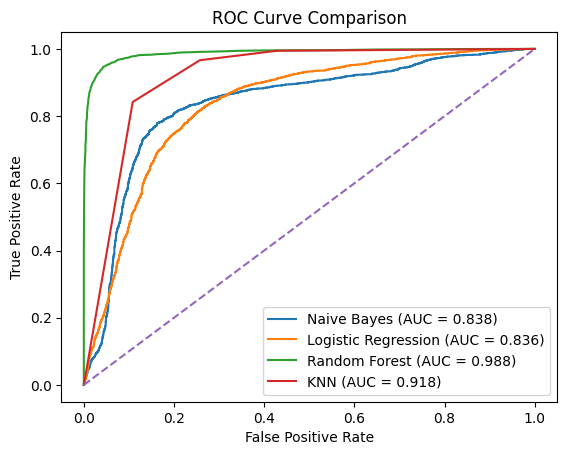

In [0]:
plt.figure()

models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": pipeline,
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}

for name, model in models.items():
    y_proba = cross_val_predict(
        model,
        X_smote,
        y_smote,
        cv=KFold(n_splits=10, shuffle=True),
        method="predict_proba"
    )[:, 1]

    fpr, tpr, _ = roc_curve(y_smote, y_proba)
    auc = roc_auc_score(y_smote, y_proba)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [0]:
kfold = KFold(n_splits=10, shuffle=True)
knn = KNeighborsClassifier(n_neighbors=3)
knn_scores = cross_val_score(knn, X_smote, y_smote, cv=kfold)
knn_scores_recalls = cross_val_score(knn, X_smote, y_smote, cv=kfold, scoring='recall')
knn_scores, knn_scores_recalls

(array([0.85263158, 0.86140351, 0.88070175, 0.84736842, 0.87368421,
        0.88245614, 0.84561404, 0.85438596, 0.82631579, 0.85087719]),
 array([0.97864769, 0.93501805, 0.97658863, 0.95652174, 0.97163121,
        0.99288256, 0.95789474, 0.95940959, 0.97069597, 0.94701987]))

In [0]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)
cm = confusion_matrix(y_smote, y_pred)
recall = recall_score(y_smote, y_pred)
precision = precision_score(y_smote, y_pred)
recall, precision, cm

(0.9943859649122807,
 0.6992351344682951,
 array([[1631, 1219],
        [  16, 2834]]))

# Testes com pesos

In [0]:
X_smote_duplicate = X_smote.copy()
X_smote_duplicate['ContractRenewalDUP'] = X_smote['ContractRenewal']
X_smote_duplicate['CustServCallsDUP'] = X_smote['CustServCalls']
random_forest_results = {}
forest_acuracy, forest_recall = [], []
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
random_forest = RandomForestClassifier(class_weight={0: 1, 1: 3})
random_forest_scores = cross_val_score(random_forest, X_smote_duplicate, y_smote, cv=kfold)
random_forest_recalls = cross_val_score(random_forest, X_smote_duplicate, y_smote, cv=kfold, scoring='recall')
forest_acuracy.append(random_forest_scores.mean())
forest_recall.append(random_forest_recalls.mean())
random_forest_results['accuracy'] = forest_acuracy
random_forest_results['recall'] = forest_recall

In [0]:
random_forest_results

{'accuracy': [np.float64(0.9536842105263158)],
 'recall': [np.float64(0.9462789239708057)]}

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1)
sample_weight = np.where(X_train["CustServCalls"] > 4, 3, 1)


random_forest_results = {}
forest_acuracy, forest_recall = [], []

random_forest = RandomForestClassifier(class_weight={0: 1, 1: 3})
random_forest = random_forest.fit(X_train, y_train, sample_weight=sample_weight)
random_forest_scores = cross_val_score(random_forest, X_test, y_test)
random_forest_recalls = cross_val_score(random_forest, X_test, y_test, scoring='recall')


forest_acuracy.append(random_forest_scores.mean())
forest_recall.append(random_forest_recalls.mean())
random_forest_results['accuracy'] = forest_acuracy
random_forest_results['recall'] = forest_recall

In [0]:
random_forest_results

{'accuracy': [np.float64(0.8947368421052632)],
 'recall': [np.float64(0.8692128551467164)]}